In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

snr_db_index = 2
snr_db=snr_db_array[snr_db_index]

Mounted at /content/drive


In [3]:
num_samples = 1000
sample_range = range(400, 600)

Sparse Bayesian Learning (SBL)

In [4]:
def casbl_anc_algorithm(theta, y, noise_var, loc, alpha=1.00, beta=0.1, rho=7, U=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if rho == 0:
        correlation_matrix = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / rho) - np.exp(-U / rho)) / (1 - np.exp(-U / rho)),0)

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute Q
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P
        P = 2 * alpha * (beta - correlation_matrix) @ np.diag(Gamma)
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
    mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [5]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(pilot_length_array)))         # HR
fr_res = np.zeros((num_samples, len(pilot_length_array)))         # FR
srr_res = np.zeros((num_samples, len(pilot_length_array)))        # SRR
precision_res = np.zeros((num_samples, len(pilot_length_array)))  # Precision
recall_res = np.zeros((num_samples, len(pilot_length_array)))     # Recall
f1_res = np.zeros((num_samples, len(pilot_length_array)))         # F1
nmse_res = np.zeros((num_samples, len(pilot_length_array)))       # NMSE

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and Pilot Length
        z_result, gamma_result = casbl_anc_algorithm(theta, received_signal, noise_power, loc)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_res[sample_index, pilot_length_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, pilot_length_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, pilot_length_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, pilot_length_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index]) > 0:
            f1_res[sample_index, pilot_length_index] = (
                2 * precision_res[sample_index, pilot_length_index] * recall_res[sample_index, pilot_length_index]
                /
                (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index])
            )
        else:
            f1_res[sample_index, pilot_length_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, pilot_length_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:36<00:18, 18.79s/it]

Converged after 415 outer iterations



Processing Samples:   0%|          | 1/200 [01:52<6:12:19, 112.26s/it]

Converged after 363 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:37, 18.57s/it]

Converged after 491 outer iterations



Processing Samples:   1%|          | 2/200 [03:47<6:15:34, 113.81s/it]

Converged after 402 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.44s/it]

Converged after 353 outer iterations



Processing Samples:   2%|▏         | 3/200 [05:32<6:01:19, 110.05s/it]

Converged after 395 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:56<00:57, 19.20s/it]

Converged after 486 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.52s/it]

Converged after 421 outer iterations



Processing Samples:   2%|▏         | 4/200 [07:22<5:58:50, 109.85s/it]

Converged after 410 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:36<00:19, 19.50s/it]

Converged after 452 outer iterations



Processing Samples:   2%|▎         | 5/200 [09:15<6:01:15, 111.16s/it]

Converged after 408 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:53<00:54, 18.12s/it]

Converged after 464 outer iterations



Processing Samples:   3%|▎         | 6/200 [11:05<5:58:03, 110.74s/it]

Converged after 387 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:36, 18.47s/it]

Converged after 465 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.96s/it]

Converged after 435 outer iterations



Processing Samples:   4%|▎         | 7/200 [12:58<5:58:42, 111.52s/it]

Converged after 419 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.60s/it]

Converged after 358 outer iterations



Processing Samples:   4%|▍         | 8/200 [14:46<5:53:13, 110.39s/it]

Converged after 439 outer iterations



Processing Samples:   4%|▍         | 9/200 [16:42<5:57:09, 112.19s/it]

Converged after 421 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.73s/it]

Converged after 447 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.79s/it]

Converged after 493 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:17, 17.86s/it]

Converged after 346 outer iterations



Processing Samples:   6%|▌         | 11/200 [20:27<5:53:50, 112.33s/it]

Converged after 442 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:38, 19.03s/it]

Converged after 463 outer iterations



Processing Samples:   6%|▌         | 12/200 [22:20<5:51:50, 112.29s/it]

Converged after 411 outer iterations



Processing Samples:   6%|▋         | 13/200 [24:18<5:55:46, 114.15s/it]

Converged after 470 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.73s/it]

Converged after 415 outer iterations



Processing Samples:   7%|▋         | 14/200 [26:14<5:55:37, 114.72s/it]

Converged after 448 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:37, 18.97s/it]

Converged after 455 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.76s/it]

Converged after 383 outer iterations



Processing Samples:   8%|▊         | 15/200 [28:03<5:48:00, 112.87s/it]

Converged after 434 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.23s/it]

Converged after 420 outer iterations



Processing Samples:   8%|▊         | 16/200 [29:51<5:41:53, 111.49s/it]

Converged after 354 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:18, 18.98s/it]

Converged after 393 outer iterations



Processing Samples:   8%|▊         | 17/200 [31:42<5:39:50, 111.42s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.56s/it]

Converged after 403 outer iterations



Processing Samples:   9%|▉         | 18/200 [33:28<5:33:05, 109.81s/it]

Converged after 284 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:16<00:39, 19.54s/it]

Converged after 498 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 19.00s/it]

Converged after 442 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.62s/it]

Converged after 410 outer iterations



Processing Samples:  10%|█         | 20/200 [37:15<5:33:39, 111.22s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.01s/it]

Converged after 436 outer iterations



Processing Samples:  10%|█         | 21/200 [39:12<5:36:51, 112.91s/it]

Converged after 433 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.45s/it]

Converged after 448 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.95s/it]

Converged after 475 outer iterations
Converged after 346 outer iterations



Processing Samples:  11%|█         | 22/200 [40:56<5:27:17, 110.32s/it]

Converged after 360 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:55<00:53, 17.89s/it]

Converged after 430 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.00s/it]

Converged after 474 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.39s/it]

Converged after 313 outer iterations



Processing Samples:  12%|█▏        | 24/200 [44:36<5:21:00, 109.44s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.50s/it]

Converged after 357 outer iterations



Processing Samples:  12%|█▎        | 25/200 [46:22<5:16:19, 108.46s/it]

Converged after 343 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:16<00:37, 18.92s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.89s/it]

Converged after 465 outer iterations



Processing Samples:  13%|█▎        | 26/200 [48:17<5:20:08, 110.40s/it]

Converged after 413 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.21s/it]

Converged after 465 outer iterations



Processing Samples:  14%|█▎        | 27/200 [50:13<5:23:47, 112.30s/it]

Converged after 430 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.08s/it]

Converged after 389 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.87s/it]

Converged after 391 outer iterations



Processing Samples:  14%|█▍        | 29/200 [53:53<5:15:38, 110.75s/it]

Converged after 362 outer iterations



Processing Samples:  15%|█▌        | 30/200 [55:46<5:16:15, 111.62s/it]

Converged after 365 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.32s/it]

Converged after 441 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.59s/it]

Converged after 408 outer iterations



Processing Samples:  16%|█▌        | 31/200 [57:32<5:08:52, 109.66s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.08s/it]

Converged after 375 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.70s/it]

Converged after 417 outer iterations



Processing Samples:  16%|█▋        | 33/200 [1:01:15<5:06:58, 110.29s/it]

Converged after 336 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:38, 19.08s/it]

Converged after 493 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.25s/it]

Converged after 421 outer iterations



Processing Samples:  17%|█▋        | 34/200 [1:03:05<5:05:25, 110.39s/it]

Converged after 473 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.69s/it]

Converged after 448 outer iterations



Processing Samples:  18%|█▊        | 35/200 [1:04:58<5:05:26, 111.07s/it]

Converged after 365 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.31s/it]

Converged after 395 outer iterations



Processing Samples:  18%|█▊        | 36/200 [1:06:43<4:58:27, 109.19s/it]

Converged after 301 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:38, 19.00s/it]

Converged after 438 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.76s/it]

Converged after 471 outer iterations



Processing Samples:  18%|█▊        | 37/200 [1:08:32<4:56:20, 109.08s/it]

Converged after 392 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.61s/it]

Converged after 381 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.76s/it]

Converged after 371 outer iterations



Processing Samples:  19%|█▉        | 38/200 [1:10:19<4:52:44, 108.42s/it]

Converged after 499 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.06s/it]

Converged after 435 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.36s/it]

Converged after 403 outer iterations



Processing Samples:  20%|█▉        | 39/200 [1:12:03<4:47:53, 107.29s/it]

Converged after 357 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.70s/it]

Converged after 399 outer iterations



Processing Samples:  20%|██        | 40/200 [1:13:49<4:44:37, 106.74s/it]

Converged after 340 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.09s/it]

Converged after 431 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.77s/it]

Converged after 437 outer iterations



Processing Samples:  20%|██        | 41/200 [1:15:40<4:46:19, 108.05s/it]

Converged after 395 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.60s/it]

Converged after 435 outer iterations



Processing Samples:  21%|██        | 42/200 [1:17:25<4:42:39, 107.34s/it]

Converged after 309 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.07s/it]

Converged after 389 outer iterations



Processing Samples:  22%|██▏       | 43/200 [1:19:14<4:41:38, 107.64s/it]

Converged after 441 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.10s/it]

Converged after 395 outer iterations



Processing Samples:  22%|██▏       | 44/200 [1:21:00<4:38:52, 107.26s/it]

Converged after 325 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:34, 17.24s/it]

Converged after 372 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.67s/it]

Converged after 391 outer iterations



Processing Samples:  22%|██▎       | 45/200 [1:22:45<4:35:23, 106.60s/it]

Converged after 458 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.45s/it]

Converged after 437 outer iterations



Processing Samples:  23%|██▎       | 46/200 [1:24:41<4:40:54, 109.45s/it]

Converged after 498 outer iterations



Processing Samples:  24%|██▎       | 47/200 [1:26:39<4:45:12, 111.85s/it]

Converged after 479 outer iterations



Processing Samples:  24%|██▍       | 48/200 [1:28:29<4:41:46, 111.23s/it]

Converged after 364 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.66s/it]

Converged after 390 outer iterations



Processing Samples:  24%|██▍       | 49/200 [1:30:20<4:40:14, 111.35s/it]

Converged after 469 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.52s/it]

Converged after 439 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.68s/it]

Converged after 355 outer iterations
Converged after 400 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.46s/it]

Converged after 418 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.05s/it]

Converged after 391 outer iterations



Processing Samples:  26%|██▌       | 51/200 [1:33:47<4:26:19, 107.25s/it]

Converged after 351 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:18, 18.89s/it]

Converged after 407 outer iterations



Processing Samples:  26%|██▌       | 52/200 [1:35:38<4:27:19, 108.38s/it]

Converged after 349 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.42s/it]

Converged after 422 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.70s/it]

Converged after 471 outer iterations



Processing Samples:  26%|██▋       | 53/200 [1:37:28<4:26:37, 108.83s/it]

Converged after 449 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.26s/it]

Converged after 422 outer iterations



Processing Samples:  27%|██▋       | 54/200 [1:39:17<4:24:49, 108.83s/it]

Converged after 395 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:16<00:38, 19.09s/it]

Converged after 499 outer iterations



Processing Samples:  28%|██▊       | 55/200 [1:41:11<4:27:06, 110.53s/it]

Converged after 388 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:38, 19.07s/it]

Converged after 474 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.82s/it]

Converged after 473 outer iterations



Processing Samples:  28%|██▊       | 56/200 [1:43:07<4:28:36, 111.92s/it]

Converged after 431 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:37, 18.92s/it]

Converged after 476 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.74s/it]

Converged after 439 outer iterations



Processing Samples:  28%|██▊       | 57/200 [1:44:53<4:22:42, 110.22s/it]

Converged after 320 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.33s/it]

Converged after 380 outer iterations



Processing Samples:  29%|██▉       | 58/200 [1:46:44<4:21:20, 110.43s/it]

Converged after 481 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.16s/it]

Converged after 421 outer iterations



Processing Samples:  30%|███       | 60/200 [1:50:37<4:25:04, 113.61s/it]

Converged after 453 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:53<00:53, 17.86s/it]

Converged after 488 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.96s/it]

Converged after 375 outer iterations



Processing Samples:  30%|███       | 61/200 [1:52:22<4:17:12, 111.03s/it]

Converged after 339 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.24s/it]

Converged after 377 outer iterations



Processing Samples:  31%|███       | 62/200 [1:54:08<4:12:01, 109.57s/it]

Converged after 321 outer iterations



Processing Samples:  32%|███▏      | 63/200 [1:55:59<4:10:38, 109.77s/it]

Converged after 300 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.22s/it]

Converged after 435 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:16, 16.91s/it]

Converged after 350 outer iterations



Processing Samples:  32%|███▏      | 64/200 [1:57:42<4:04:42, 107.96s/it]

Converged after 361 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.04s/it]

Converged after 324 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.48s/it]

Converged after 467 outer iterations



Processing Samples:  32%|███▎      | 65/200 [1:59:27<4:00:59, 107.10s/it]

Converged after 404 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.79s/it]

Converged after 481 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.97s/it]

Converged after 368 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.22s/it]

Converged after 371 outer iterations



Processing Samples:  34%|███▎      | 67/200 [2:03:06<3:59:38, 108.11s/it]

Converged after 340 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:38, 19.44s/it]

Converged after 484 outer iterations



Processing Samples:  34%|███▍      | 68/200 [2:04:59<4:00:59, 109.54s/it]

Converged after 437 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:18, 18.90s/it]

Converged after 394 outer iterations



Processing Samples:  34%|███▍      | 69/200 [2:06:52<4:01:02, 110.40s/it]

Converged after 408 outer iterations



Processing Samples:  35%|███▌      | 70/200 [2:08:50<4:04:20, 112.77s/it]

Converged after 458 outer iterations



Processing Samples:  36%|███▌      | 71/200 [2:10:38<3:59:33, 111.42s/it]

Converged after 320 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.96s/it]

Converged after 476 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.44s/it]

Converged after 471 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:37, 18.62s/it]

Converged after 449 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.56s/it]

Converged after 474 outer iterations



Processing Samples:  36%|███▋      | 73/200 [2:14:23<3:56:06, 111.55s/it]

Converged after 416 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.42s/it]

Converged after 371 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.89s/it]

Converged after 479 outer iterations



Processing Samples:  37%|███▋      | 74/200 [2:16:11<3:51:55, 110.44s/it]

Converged after 439 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.41s/it]

Converged after 471 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.92s/it]

Converged after 436 outer iterations



Processing Samples:  38%|███▊      | 75/200 [2:18:05<3:52:26, 111.57s/it]

Converged after 482 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.40s/it]

Converged after 445 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.93s/it]

Converged after 344 outer iterations



Processing Samples:  38%|███▊      | 76/200 [2:19:47<3:44:44, 108.74s/it]

Converged after 341 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:38, 19.30s/it]

Converged after 491 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.87s/it]

Converged after 471 outer iterations



Processing Samples:  38%|███▊      | 77/200 [2:21:36<3:43:05, 108.83s/it]

Converged after 389 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:19, 19.00s/it]

Converged after 481 outer iterations



Processing Samples:  39%|███▉      | 78/200 [2:23:25<3:41:24, 108.89s/it]

Converged after 360 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:34, 17.47s/it]

Converged after 396 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.77s/it]

Converged after 467 outer iterations



Processing Samples:  40%|███▉      | 79/200 [2:25:10<3:37:05, 107.65s/it]

Converged after 331 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.89s/it]

Converged after 486 outer iterations



Processing Samples:  40%|████      | 80/200 [2:27:03<3:38:26, 109.22s/it]

Converged after 375 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:38, 19.43s/it]

Converged after 495 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.24s/it]

Converged after 408 outer iterations



Processing Samples:  40%|████      | 81/200 [2:28:51<3:35:53, 108.86s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.76s/it]

Converged after 401 outer iterations



Processing Samples:  41%|████      | 82/200 [2:30:45<3:37:00, 110.34s/it]

Converged after 466 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.45s/it]

Converged after 488 outer iterations



Processing Samples:  42%|████▏     | 83/200 [2:32:34<3:34:34, 110.04s/it]

Converged after 324 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.72s/it]

Converged after 453 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.44s/it]

Converged after 458 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:38, 19.43s/it]

Converged after 471 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.18s/it]

Converged after 395 outer iterations



Processing Samples:  42%|████▎     | 85/200 [2:36:13<3:29:26, 109.28s/it]

Converged after 315 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:53<00:52, 17.42s/it]

Converged after 435 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:19, 19.49s/it]

Converged after 486 outer iterations



Processing Samples:  43%|████▎     | 86/200 [2:38:04<3:28:31, 109.75s/it]

Converged after 411 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:37, 18.50s/it]

Converged after 454 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.46s/it]

Converged after 388 outer iterations



Processing Samples:  44%|████▎     | 87/200 [2:39:48<3:23:33, 108.09s/it]

Converged after 355 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.75s/it]

Converged after 472 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.16s/it]

Converged after 441 outer iterations



Processing Samples:  44%|████▍     | 88/200 [2:41:38<3:22:33, 108.51s/it]

Converged after 449 outer iterations



Processing Samples:  44%|████▍     | 89/200 [2:43:32<3:23:36, 110.06s/it]

Converged after 385 outer iterations



Processing Samples:  45%|████▌     | 90/200 [2:45:23<3:22:31, 110.47s/it]

Converged after 413 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.41s/it]

Converged after 483 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.31s/it]

Converged after 381 outer iterations



Processing Samples:  46%|████▌     | 91/200 [2:47:07<3:17:09, 108.53s/it]

Converged after 319 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.39s/it]

Converged after 363 outer iterations



Processing Samples:  46%|████▌     | 92/200 [2:48:59<3:17:08, 109.52s/it]

Converged after 423 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.27s/it]

Converged after 417 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.69s/it]

Converged after 341 outer iterations



Processing Samples:  46%|████▋     | 93/200 [2:50:43<3:12:32, 107.96s/it]

Converged after 423 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:38, 19.05s/it]

Converged after 439 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.41s/it]

Converged after 425 outer iterations



Processing Samples:  47%|████▋     | 94/200 [2:52:31<3:10:26, 107.80s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:55<00:56, 18.85s/it]

Converged after 464 outer iterations



Processing Samples:  48%|████▊     | 95/200 [2:54:18<3:08:41, 107.82s/it]

Converged after 335 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.50s/it]

Converged after 359 outer iterations



Processing Samples:  48%|████▊     | 96/200 [2:56:09<3:08:32, 108.77s/it]

Converged after 428 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:37, 18.53s/it]

Converged after 472 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.25s/it]

Converged after 396 outer iterations



Processing Samples:  48%|████▊     | 97/200 [2:57:50<3:02:41, 106.42s/it]

Converged after 307 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:54<00:52, 17.57s/it]

Converged after 435 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.95s/it]

Converged after 371 outer iterations
Converged after 417 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.67s/it]

Converged after 418 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.63s/it]

Converged after 439 outer iterations



Processing Samples:  50%|████▉     | 99/200 [3:01:25<2:59:53, 106.86s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:08<00:33, 16.90s/it]

Converged after 380 outer iterations



Processing Samples:  50%|█████     | 100/200 [3:03:14<2:59:28, 107.69s/it]

Converged after 448 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:36<00:19, 19.90s/it]

Converged after 348 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.53s/it]

Converged after 319 outer iterations



Processing Samples:  51%|█████     | 102/200 [3:06:46<2:53:47, 106.40s/it]

Converged after 311 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:16, 16.81s/it]

Converged after 313 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.38s/it]

Converged after 395 outer iterations



Processing Samples:  52%|█████▏    | 104/200 [3:10:24<2:52:11, 107.62s/it]

Converged after 363 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.61s/it]

Converged after 497 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.77s/it]

Converged after 369 outer iterations



Processing Samples:  52%|█████▎    | 105/200 [3:12:09<2:49:07, 106.82s/it]

Converged after 366 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:37, 18.82s/it]

Converged after 474 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:19, 19.06s/it]

Converged after 495 outer iterations



Processing Samples:  53%|█████▎    | 106/200 [3:14:00<2:49:10, 107.99s/it]

Converged after 431 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:34, 17.35s/it]

Converged after 380 outer iterations



Processing Samples:  54%|█████▎    | 107/200 [3:15:53<2:49:27, 109.33s/it]

Converged after 460 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:53, 17.67s/it]

Converged after 490 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.06s/it]

Converged after 383 outer iterations



Processing Samples:  54%|█████▍    | 108/200 [3:17:38<2:45:45, 108.11s/it]

Converged after 334 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.06s/it]

Converged after 404 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.58s/it]

Converged after 395 outer iterations



Processing Samples:  55%|█████▍    | 109/200 [3:19:17<2:39:56, 105.45s/it]

Converged after 325 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:35, 17.93s/it]

Converged after 447 outer iterations



Processing Samples:  55%|█████▌    | 110/200 [3:21:10<2:41:39, 107.78s/it]

Converged after 408 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:51, 17.14s/it]

Converged after 463 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.30s/it]

Converged after 381 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:18, 18.16s/it]

Converged after 469 outer iterations



Processing Samples:  56%|█████▌    | 111/200 [3:22:53<2:37:50, 106.41s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.29s/it]

Converged after 400 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:49, 16.62s/it]

Converged after 362 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.25s/it]

Converged after 434 outer iterations



Processing Samples:  56%|█████▋    | 113/200 [3:26:28<2:34:19, 106.43s/it]

Converged after 350 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.59s/it]

Converged after 468 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.88s/it]

Converged after 418 outer iterations



Processing Samples:  57%|█████▋    | 114/200 [3:28:14<2:32:16, 106.24s/it]

Converged after 331 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.59s/it]

Converged after 389 outer iterations



Processing Samples:  57%|█████▊    | 115/200 [3:30:00<2:30:35, 106.29s/it]

Converged after 380 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.69s/it]

Converged after 440 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:16, 16.93s/it]

Converged after 396 outer iterations



Processing Samples:  58%|█████▊    | 116/200 [3:31:44<2:27:36, 105.43s/it]

Converged after 363 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.16s/it]

Converged after 434 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.19s/it]

Converged after 427 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.16s/it]

Converged after 385 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:37<00:20, 20.03s/it]

Converged after 471 outer iterations



Processing Samples:  60%|█████▉    | 119/200 [3:37:21<2:28:33, 110.05s/it]

Converged after 401 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:19, 19.15s/it]

Converged after 475 outer iterations



Processing Samples:  60%|██████    | 120/200 [3:39:11<2:26:26, 109.84s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.41s/it]

Converged after 480 outer iterations



Processing Samples:  60%|██████    | 121/200 [3:40:57<2:23:00, 108.62s/it]

Converged after 297 outer iterations



Processing Samples:  61%|██████    | 122/200 [3:42:51<2:23:23, 110.30s/it]

Converged after 412 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.93s/it]

Converged after 450 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.40s/it]

Converged after 441 outer iterations



Processing Samples:  62%|██████▏   | 123/200 [3:44:42<2:21:54, 110.58s/it]

Converged after 482 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.09s/it]

Converged after 413 outer iterations



Processing Samples:  62%|██████▏   | 124/200 [3:46:32<2:19:52, 110.42s/it]

Converged after 346 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.87s/it]

Converged after 453 outer iterations



Processing Samples:  62%|██████▎   | 125/200 [3:48:24<2:18:33, 110.84s/it]

Converged after 446 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.85s/it]

Converged after 438 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.14s/it]

Converged after 489 outer iterations



Processing Samples:  63%|██████▎   | 126/200 [3:50:16<2:17:15, 111.29s/it]

Converged after 448 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.93s/it]

Converged after 375 outer iterations



Processing Samples:  64%|██████▎   | 127/200 [3:52:03<2:13:42, 109.90s/it]

Converged after 394 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:33<01:06, 16.65s/it]

Converged after 458 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.59s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.29s/it]

Converged after 396 outer iterations



Processing Samples:  64%|██████▍   | 128/200 [3:53:39<2:06:56, 105.79s/it]

Converged after 309 outer iterations



Processing Samples:  64%|██████▍   | 129/200 [3:55:35<2:08:48, 108.86s/it]

Converged after 444 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:19, 19.04s/it]

Converged after 427 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:33, 16.79s/it]

Converged after 377 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.42s/it]

Converged after 394 outer iterations



Processing Samples:  66%|██████▌   | 131/200 [3:59:10<2:03:45, 107.61s/it]

Converged after 401 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.39s/it]

Converged after 481 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.68s/it]

Converged after 413 outer iterations



Processing Samples:  66%|██████▌   | 132/200 [4:01:02<2:03:27, 108.93s/it]

Converged after 436 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.30s/it]

Converged after 404 outer iterations



Processing Samples:  66%|██████▋   | 133/200 [4:02:50<2:01:19, 108.64s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.89s/it]

Converged after 477 outer iterations



Processing Samples:  67%|██████▋   | 134/200 [4:04:38<1:59:26, 108.59s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:36<00:19, 19.75s/it]

Converged after 485 outer iterations



Processing Samples:  68%|██████▊   | 135/200 [4:06:32<1:59:17, 110.11s/it]

Converged after 404 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:08<00:34, 17.06s/it]

Converged after 405 outer iterations



Processing Samples:  68%|██████▊   | 136/200 [4:08:18<1:56:14, 108.98s/it]

Converged after 330 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.98s/it]

Converged after 457 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.81s/it]

Converged after 483 outer iterations



Processing Samples:  68%|██████▊   | 137/200 [4:10:08<1:54:39, 109.20s/it]

Converged after 418 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.63s/it]

Converged after 415 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.49s/it]

Converged after 355 outer iterations



Processing Samples:  69%|██████▉   | 138/200 [4:11:53<1:51:30, 107.92s/it]

Converged after 463 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.99s/it]

Converged after 433 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.31s/it]

Converged after 421 outer iterations



Processing Samples:  70%|███████   | 141/200 [4:17:33<1:49:09, 111.00s/it]

Converged after 350 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:37, 18.76s/it]

Converged after 475 outer iterations



Processing Samples:  71%|███████   | 142/200 [4:19:28<1:48:32, 112.28s/it]

Converged after 428 outer iterations



Processing Samples:  72%|███████▏  | 143/200 [4:21:18<1:46:02, 111.62s/it]

Converged after 411 outer iterations



Processing Samples:  72%|███████▏  | 144/200 [4:23:11<1:44:27, 111.93s/it]

Converged after 411 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.32s/it]

Converged after 492 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:19, 19.01s/it]

Converged after 468 outer iterations



Processing Samples:  72%|███████▎  | 145/200 [4:24:59<1:41:42, 110.96s/it]

Converged after 397 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:51, 17.11s/it]

Converged after 464 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.30s/it]

Converged after 383 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.88s/it]

Converged after 373 outer iterations



Processing Samples:  73%|███████▎  | 146/200 [4:26:39<1:36:53, 107.65s/it]

Converged after 381 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.43s/it]

Converged after 407 outer iterations



Processing Samples:  74%|███████▎  | 147/200 [4:28:29<1:35:32, 108.17s/it]

Converged after 422 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.21s/it]

Converged after 423 outer iterations



Processing Samples:  74%|███████▍  | 148/200 [4:30:15<1:33:13, 107.58s/it]

Converged after 330 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.47s/it]

Converged after 362 outer iterations



Processing Samples:  74%|███████▍  | 149/200 [4:31:59<1:30:40, 106.67s/it]

Converged after 349 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:49, 16.43s/it]

Converged after 405 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.49s/it]

Converged after 384 outer iterations



Processing Samples:  75%|███████▌  | 150/200 [4:33:41<1:27:45, 105.31s/it]

Converged after 348 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.44s/it]

Converged after 427 outer iterations



Processing Samples:  76%|███████▌  | 152/200 [4:37:26<1:26:38, 108.30s/it]

Converged after 351 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.49s/it]

Converged after 439 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.35s/it]

Converged after 442 outer iterations



Processing Samples:  76%|███████▋  | 153/200 [4:39:16<1:25:19, 108.93s/it]

Converged after 464 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.46s/it]

Converged after 489 outer iterations



Processing Samples:  77%|███████▋  | 154/200 [4:41:12<1:25:04, 110.97s/it]

Converged after 442 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:37, 18.57s/it]

Converged after 463 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.70s/it]

Converged after 496 outer iterations



Processing Samples:  78%|███████▊  | 155/200 [4:43:05<1:23:43, 111.62s/it]

Converged after 440 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.80s/it]

Converged after 450 outer iterations



Processing Samples:  78%|███████▊  | 156/200 [4:44:55<1:21:37, 111.31s/it]

Converged after 391 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.96s/it]

Converged after 483 outer iterations



Processing Samples:  78%|███████▊  | 157/200 [4:46:47<1:19:44, 111.26s/it]

Converged after 433 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:33, 16.61s/it]

Converged after 327 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.42s/it]

Converged after 492 outer iterations



Processing Pilot Length Levels: 100%|██████████| 6/6 [01:49<00:00, 18.60s/it]


Converged after 433 outer iterations


Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.70s/it]

Converged after 431 outer iterations



Processing Samples:  80%|███████▉  | 159/200 [4:50:25<1:15:17, 110.18s/it]

Converged after 371 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:54<00:54, 18.26s/it]

Converged after 477 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:32, 16.29s/it]

Converged after 374 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:17, 17.12s/it]

Converged after 398 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:38, 19.29s/it]

Converged after 497 outer iterations



Processing Samples:  80%|████████  | 161/200 [4:54:04<1:11:33, 110.08s/it]

Converged after 386 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.84s/it]

Converged after 424 outer iterations



Processing Samples:  81%|████████  | 162/200 [4:55:52<1:09:17, 109.42s/it]

Converged after 311 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.19s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.49s/it]

Converged after 444 outer iterations



Processing Samples:  82%|████████▏ | 163/200 [4:57:38<1:06:57, 108.57s/it]

Converged after 382 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.41s/it]

Converged after 473 outer iterations



Processing Samples:  82%|████████▏ | 164/200 [4:59:28<1:05:15, 108.77s/it]

Converged after 364 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.83s/it]

Converged after 426 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.23s/it]

Converged after 495 outer iterations



Processing Samples:  82%|████████▎ | 165/200 [5:01:15<1:03:10, 108.31s/it]

Converged after 363 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.09s/it]

Converged after 431 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:16, 16.93s/it]

Converged after 364 outer iterations



Processing Samples:  83%|████████▎ | 166/200 [5:03:05<1:01:39, 108.82s/it]

Converged after 435 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:48, 16.26s/it]

Converged after 380 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:33, 16.71s/it]

Converged after 459 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.68s/it]

Converged after 420 outer iterations



Processing Samples:  84%|████████▎ | 167/200 [5:04:43<58:09, 105.74s/it]  

Converged after 339 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:35, 17.92s/it]

Converged after 442 outer iterations



Processing Samples:  84%|████████▍ | 168/200 [5:06:31<56:45, 106.43s/it]

Converged after 309 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.27s/it]

Converged after 389 outer iterations



Processing Samples:  84%|████████▍ | 169/200 [5:08:19<55:13, 106.89s/it]

Converged after 392 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.60s/it]

Converged after 429 outer iterations



Processing Samples:  85%|████████▌ | 170/200 [5:10:09<53:53, 107.77s/it]

Converged after 404 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.30s/it]

Converged after 468 outer iterations



Processing Samples:  86%|████████▌ | 171/200 [5:12:03<53:00, 109.68s/it]

Converged after 415 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:33, 16.71s/it]

Converged after 392 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.86s/it]

Converged after 499 outer iterations



Processing Samples:  86%|████████▌ | 172/200 [5:13:48<50:32, 108.30s/it]

Converged after 338 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:51, 17.14s/it]

Converged after 446 outer iterations



Processing Samples:  86%|████████▋ | 173/200 [5:15:38<48:55, 108.74s/it]

Converged after 394 outer iterations



Processing Samples:  87%|████████▋ | 174/200 [5:17:36<48:17, 111.44s/it]

Converged after 484 outer iterations



Processing Samples:  88%|████████▊ | 175/200 [5:19:25<46:09, 110.76s/it]

Converged after 360 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.04s/it]

Converged after 346 outer iterations



Processing Samples:  88%|████████▊ | 176/200 [5:21:09<43:25, 108.56s/it]

Converged after 335 outer iterations



Processing Samples:  88%|████████▊ | 177/200 [5:22:58<41:41, 108.78s/it]

Converged after 310 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.18s/it]

Converged after 482 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.75s/it]

Converged after 329 outer iterations



Processing Samples:  89%|████████▉ | 178/200 [5:24:40<39:06, 106.67s/it]

Converged after 331 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.77s/it]

Converged after 429 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.17s/it]

Converged after 409 outer iterations



Processing Samples:  90%|████████▉ | 179/200 [5:26:24<37:08, 106.11s/it]

Converged after 392 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.25s/it]

Converged after 471 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.80s/it]

Converged after 434 outer iterations



Processing Samples:  90%|█████████ | 180/200 [5:28:11<35:24, 106.22s/it]

Converged after 365 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.01s/it]

Converged after 434 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.24s/it]

Converged after 459 outer iterations



Processing Samples:  90%|█████████ | 181/200 [5:30:01<33:59, 107.34s/it]

Converged after 344 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.35s/it]

Converged after 411 outer iterations



Processing Samples:  91%|█████████ | 182/200 [5:31:47<32:06, 107.05s/it]

Converged after 356 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.98s/it]

Converged after 379 outer iterations



Processing Samples:  92%|█████████▏| 183/200 [5:33:33<30:11, 106.56s/it]

Converged after 354 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:19, 19.13s/it]

Converged after 476 outer iterations



Processing Samples:  92%|█████████▏| 184/200 [5:35:20<28:31, 106.94s/it]

Converged after 327 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.32s/it]

Converged after 431 outer iterations



Processing Samples:  92%|█████████▎| 185/200 [5:37:07<26:43, 106.90s/it]

Converged after 342 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.45s/it]

Converged after 454 outer iterations



Processing Samples:  93%|█████████▎| 186/200 [5:38:56<25:03, 107.36s/it]

Converged after 358 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:55<00:54, 18.11s/it]

Converged after 467 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.14s/it]

Converged after 481 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.36s/it]

Converged after 380 outer iterations



Processing Samples:  94%|█████████▎| 187/200 [5:40:41<23:06, 106.66s/it]

Converged after 366 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:37, 18.63s/it]

Converged after 478 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.73s/it]

Converged after 474 outer iterations



Processing Samples:  94%|█████████▍| 188/200 [5:42:32<21:37, 108.12s/it]

Converged after 336 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.54s/it]

Converged after 419 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.41s/it]

Converged after 474 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.46s/it]

Converged after 394 outer iterations
Converged after 465 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.31s/it]

Converged after 477 outer iterations



Processing Samples:  96%|█████████▌| 191/200 [5:48:05<16:27, 109.72s/it]

Converged after 343 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.07s/it]

Converged after 398 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:16, 16.94s/it]

Converged after 370 outer iterations



Processing Samples:  96%|█████████▌| 192/200 [5:49:48<14:21, 107.69s/it]

Converged after 352 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.60s/it]

Converged after 346 outer iterations



Processing Samples:  96%|█████████▋| 193/200 [5:51:32<12:26, 106.67s/it]

Converged after 350 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:19, 19.17s/it]

Converged after 493 outer iterations



Processing Samples:  97%|█████████▋| 194/200 [5:53:20<10:43, 107.23s/it]

Converged after 357 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.85s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.62s/it]

Converged after 351 outer iterations



Processing Samples:  98%|█████████▊| 195/200 [5:55:00<08:45, 105.01s/it]

Converged after 312 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.52s/it]

Converged after 444 outer iterations



Processing Samples:  98%|█████████▊| 196/200 [5:56:52<07:08, 107.03s/it]

Converged after 479 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.16s/it]

Converged after 417 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.09s/it]

Converged after 374 outer iterations



Processing Samples:  98%|█████████▊| 197/200 [5:58:39<05:20, 107.00s/it]

Converged after 427 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:19, 19.74s/it]

Converged after 481 outer iterations



Processing Samples:  99%|█████████▉| 198/200 [6:00:32<03:37, 108.74s/it]

Converged after 339 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:37, 18.54s/it]

Converged after 447 outer iterations



Processing Samples: 100%|█████████▉| 199/200 [6:02:20<01:48, 108.58s/it]

Converged after 365 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.36s/it]

Converged after 464 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.06s/it]

Converged after 448 outer iterations



Processing Samples: 100%|██████████| 200/200 [6:04:08<00:00, 109.24s/it]

Converged after 406 outer iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [13.415 17.78  19.525 19.865 19.94  19.945]
Avg SRR : [0.07819003 0.12770323 0.16279159 0.18018455 0.18738286 0.19138106]
Avg FR  : [0.56921053 0.35921053 0.19921053 0.10710526 0.06789474 0.04421053]
Avg PR  : [0.11206506 0.14613932 0.16870948 0.1821919  0.18836583 0.19235887]
Avg RE  : [0.13415 0.1778  0.19525 0.19865 0.1994  0.19945]
Avg F1  : [0.12188094 0.16008998 0.18069232 0.18986472 0.19359076 0.19572541]
Avg NMSE: [0.11098267 0.06143247 0.03060014 0.01886614 0.01302827 0.01005761]


In [8]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-1000-casbl-anc-alpha-1-00-beta-0-10-snr-db-12-pilot-length-all-set-3.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length_array=pilot_length_array,
    snr_db=snr_db
)

print("All results have been saved")

All results have been saved


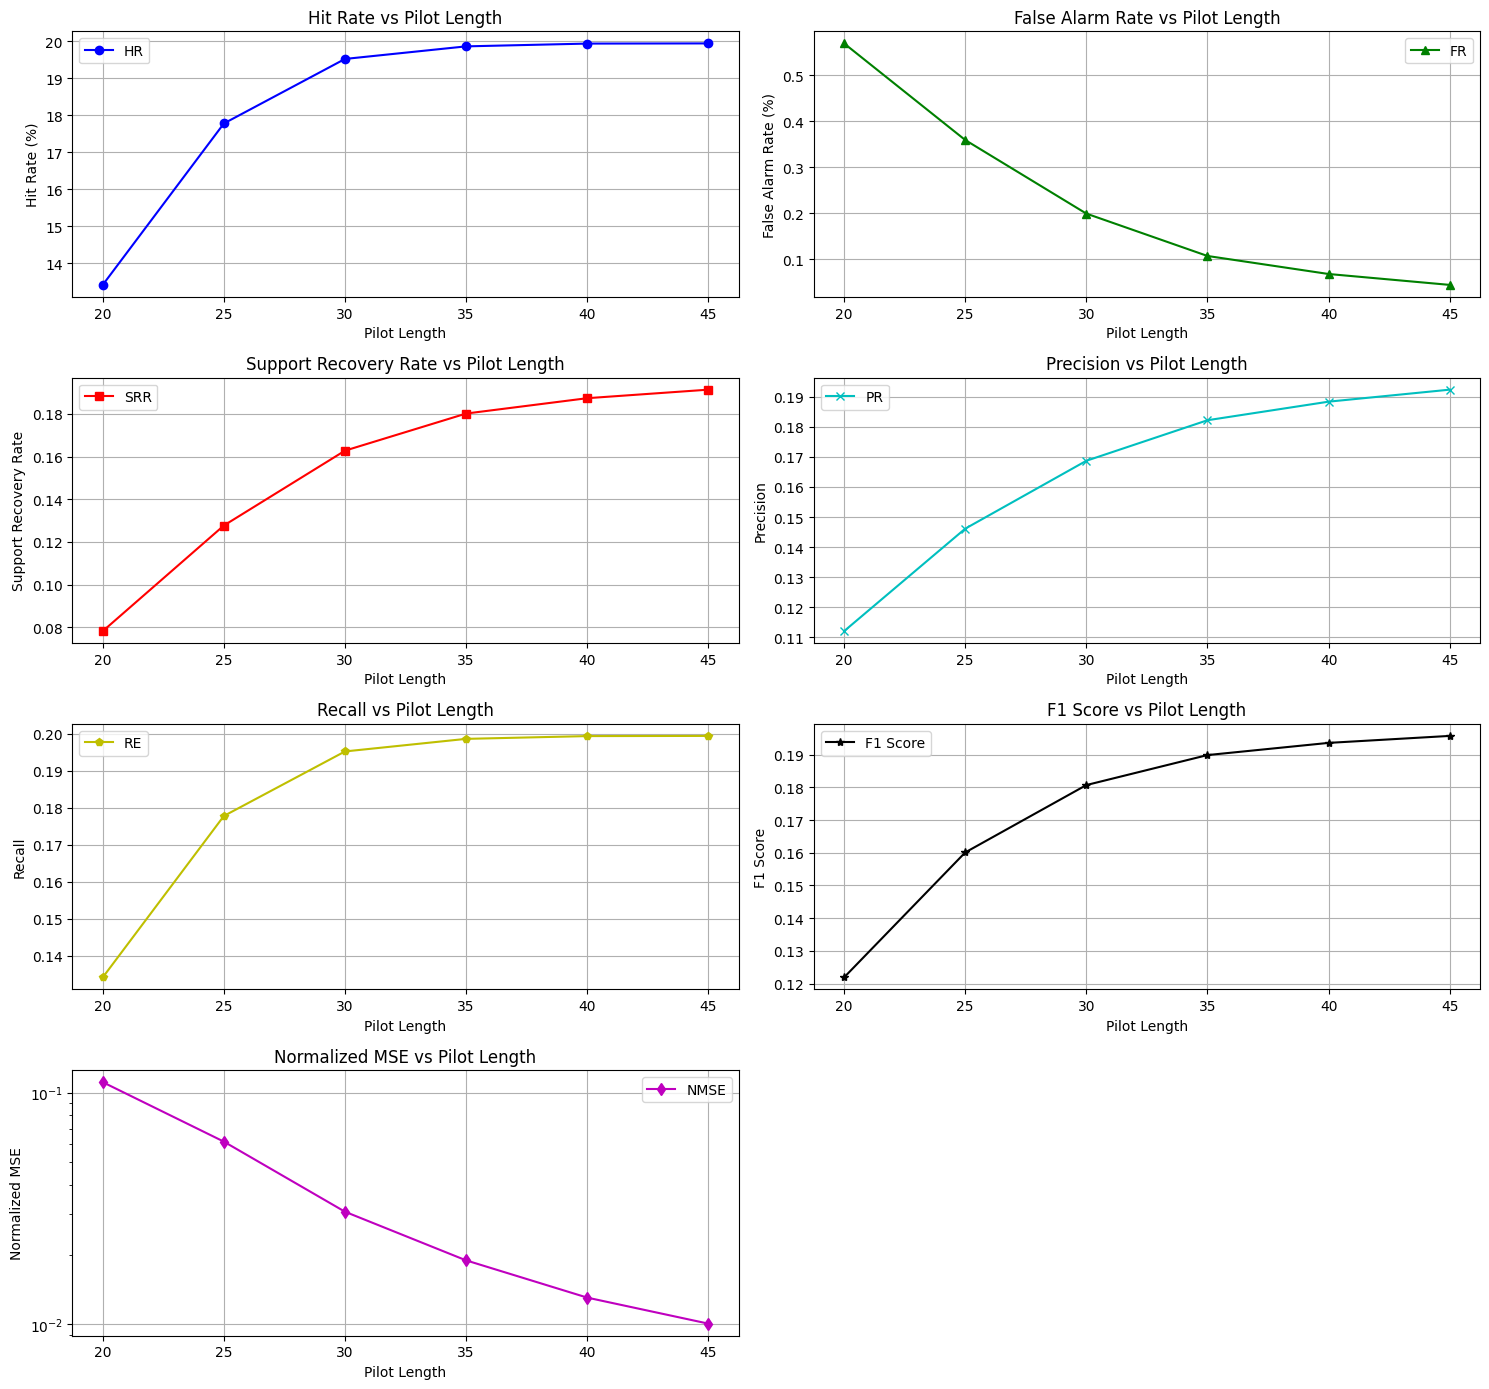

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(pilot_length_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(pilot_length_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(pilot_length_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("Pilot Length")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(pilot_length_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("Pilot Length")
plt.ylabel("Precision")
plt.title("Precision vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(pilot_length_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("Pilot Length")
plt.ylabel("Recall")
plt.title("Recall vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(pilot_length_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("Pilot Length")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(pilot_length_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

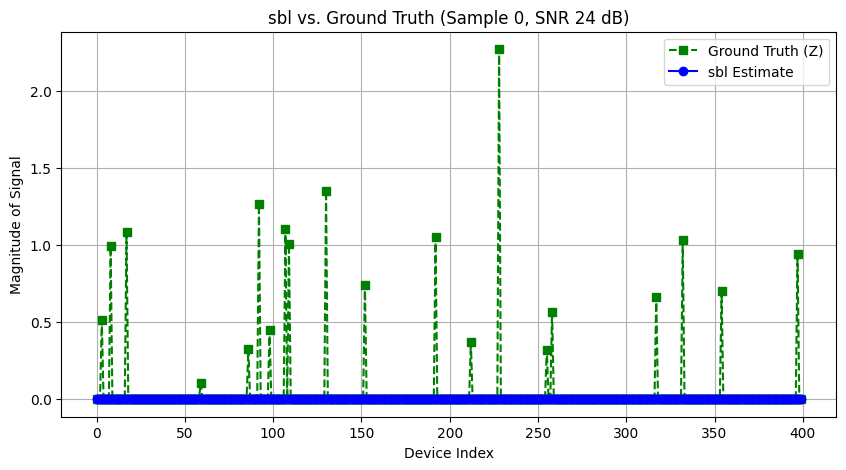

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


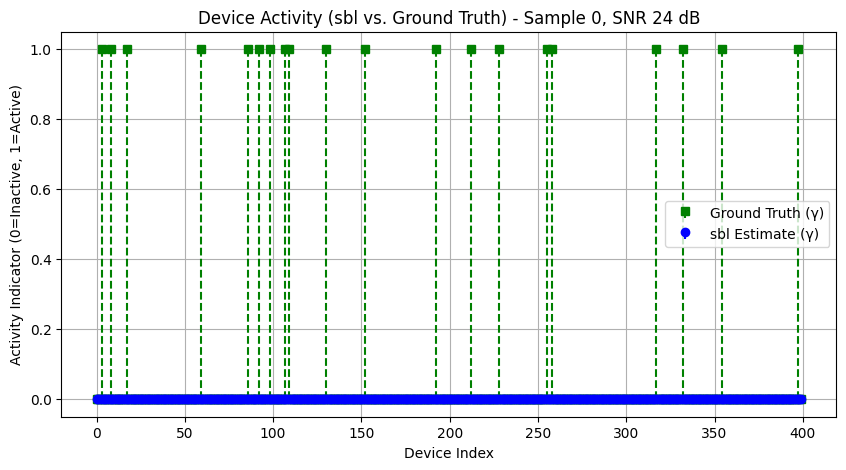

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)